In [3]:
import pickle
import os
import numpy as np
import torch.nn.functional as F 
import torch
import pandas as pd
import anndata as ad
from scETM import scETM
from multiprocessing import Pool

os.getcwd()

'd:\\1998c\\Documents\\Research\\202002scRNA\\package_release\\scETM\\scripts\\heatmap_fig'

In [4]:
working_dir = 'AD'

In [5]:
adata = ad.read_h5ad('../../../../data/AD/AD.h5ad')
model = scETM(adata.n_vars, adata.obs.batch_indices.nunique())
model.load_state_dict(torch.load('AD/model-1200'))
model.get_all_embeddings_and_nll(adata)

delta, alpha, rho = map(pd.DataFrame, [adata.obsm['delta'], adata.uns['alpha'], adata.varm['rho']])
delta.index = adata.obs_names
rho.index = adata.var_names
delta.shape, alpha.shape, rho.shape

[2021-08-12 08:19:42,211] INFO - scETM.logging_utils: scETM.__init__(17926, 48)


((70634, 50), (50, 400), (17926, 400))

In [6]:
adata

AnnData object with n_obs × n_vars = 70634 × 17926
    obs: 'cell_types', 'batch_indices', 'sub_cell_type', 'condition', 'total_counts', 'leiden_0.001', 'leiden_0.002', 'leiden_0.004', 'leiden_0.008', 'leiden_0.012', 'leiden_0.016', 'leiden_0.02', 'leiden_0.025', 'leiden_0.03', 'silhouette_width'
    uns: 'alpha'
    obsm: 'delta', 'theta'
    varm: 'rho'

In [7]:
print('Get top 30 genes per topic (for enrichment analysis)')
beta = rho @ alpha.T  # (gene, topic)

top_words = pd.DataFrame(adata.var_names.values[np.argsort(beta.values, axis=0)[:-31:-1]])  # (n_top, topic)
top_words.to_csv(os.path.join(working_dir, 'beta_top30genes.csv'))

Get top 30 genes per topic (for enrichment analysis)


In [79]:
print('Saving unnormliazed topic mixture delta')
delta.to_csv(os.path.join(working_dir, 'delta.csv'))

print('Saving metadata')
## create meta csv (condition, individual_id, cell_type)
adata.obs.to_csv(os.path.join(working_dir, 'meta.csv'))

print('Saving normalized topic mixture theta')
theta = torch.tensor(delta.values).softmax(dim=-1).detach().cpu().numpy()
theta = pd.DataFrame(theta, index=adata.obs_names)
theta.to_csv(os.path.join(working_dir, 'theta.csv'))

Saving unnormliazed topic mixture delta
Saving metadata
Saving normalized topic mixture theta


In [14]:
# by default, keep all topics
print('Sampling theta')
delta_sample = delta.sample(10000)
topic_kept = delta_sample.columns[delta_sample.sum(0) >= 1500]  # (topics)
meta_sample = adata.obs.loc[delta_sample.index]
delta_sample.to_csv(os.path.join(working_dir, 'delta_sampled.csv'))
meta_sample.to_csv(os.path.join(working_dir, 'meta_sampled.csv'))

delta_kept = delta[topic_kept]  # (cells, topics)

In [47]:
print("Pathway enrichment analysis")
from pathdip import pathDIP_Http 

n_topics = delta.shape[1]
component = "Literature curated (core) pathway memberships"
sources = "ACSN2,BioCarta,EHMN,HumanCyc,INOH,IPAVS,KEGG,NetPath,OntoCancro,Panther_Pathway,PharmGKB,PID,RB-Pathways,REACTOME,stke,systems-biology.org,SignaLink2.0,SIGNOR2.0,SMPDB,Spike,UniProt_Pathways,WikiPathways"
o = pathDIP_Http()
pathway_df=[]
for i in range(n_topics):
    IDs = ', '.join(top_words[i])
    o.searchOnGenesymbols(IDs, component, sources)
    result = o.getPathwayAnalysis().split('\n')[1:]
    for line in result:
        p = line.split('\t')[:-1]
        p.append(i)
        if len(p) == 1:
            continue
        pathway_df.append(p)
pathway_df = pd.DataFrame(pathway_df, columns = ['pathway_source','pathway_name','p_val','q_val_BH','q_val_Bonf','topic'])  # (pathways, features)

pathway_df['q_val_BH'] = pathway_df['q_val_BH'].astype(float)
pathway_df = pathway_df[pathway_df['q_val_BH'] < 0.05]
pathway_df.to_csv(os.path.join(working_dir, 'pathways.csv'))

Pathway enrichment analysis

  Search on Uniprot IDs:  

Generated at: Generated at 2021-08-11 16:52:57, by pathDip published at November 6, 2020, version 4.0.21.4; Database version 4.0.7.0.
IDs: O15379,P15692,P13236,P13236,P13236,Q96P48,O00468
DataComponent: Literature curated (core) pathway memberships
Sources: ACSN2,BioCarta,EHMN,HumanCyc,INOH,IPAVS,KEGG,NetPath,OntoCancro,Panther_Pathway,PharmGKB,PID,RB-Pathways,REACTOME,stke,systems-biology.org,SignaLink2.0,SIGNOR2.0,SMPDB,Spike,UniProt_Pathways,WikiPathways

Pathway enrichment analysis results size: 63
Pathway enrichment analysis results ('q-value (FDR: BH-method) less than 0.05'): 
Pathway Source	Pathway Name	p-value	q-value (FDR: BH-method)	q-value (Bonferroni)	External Source ID
systems-biology.org	Toll-Like_receptor_signaling_network	1.91523e-07	4.42418e-05	4.42418e-05	n/a
REACTOME	Transcriptional activation of mitochondrial biogenesis	1.89995e-02	4.61988e-02	1.00000e+00	n/a
REACTOME	Chondroitin sulfate/dermatan sulfate metab

In [10]:
print('Starting permutation test for cell types')
def simulate_mean_diff_once(data, rng: np.random.Generator):
    half = len(data) // 2
    ind = np.arange(len(data))
    rng.shuffle(ind)
    md = data[ind[:half]].mean(0) - data[ind[half:half * 2]].mean(0)
    return md

def simulate_mean_diff(data, repeats, seed):
    rng = np.random.default_rng(seed)
    mds = []
    for _ in range(repeats):
        mds.append(simulate_mean_diff_once(data, rng))
    return mds

types = adata.obs.cell_types.unique()
mds = []

reps = 10000
n_jobs = 10
# WARNING: Multithreading does not work in notebook, please run multithread_perm.py
with Pool(n_jobs) as p:
    l = [p.apply_async(simulate_mean_diff, (delta_kept.values, reps // n_jobs, seed)) for seed in range(n_jobs)]
    l = [e.get() for e in l]
    mds_simulated = np.concatenate(l, axis=0)
for t in types:
    test = delta_kept[adata.obs.cell_types == t]  # (cells_test, topics)
    ctrl = delta_kept[adata.obs.cell_types != t]  # (cells_ctrl, topics)
    md = test.mean(0) - ctrl.mean(0)  # (topics)
    mds.append(md)
mds = np.array(mds)  # (cell_types, topics)
mds_simulated = np.array(mds_simulated)

pvals = (mds_simulated.T[None, ...] > mds[..., None]).sum(-1) + 1 / (reps + 1)  # (cell_types, topics, *repeats*)
pval_df = pd.DataFrame(pvals, index=types, columns=topic_kept)  # (cell_types, topics)
pval_df = pval_df * 100 * len(types)
pval_df.to_csv(os.path.join(working_dir, 'perm_p_onesided_celltype.csv'))

mds = pd.DataFrame(mds, index=types, columns=topic_kept)
mds.to_csv(os.path.join(working_dir, 'perm_mean_celltype.csv'))

Starting permutation test for cell types


In [11]:
print('Selecting interesting topics to plot beta')
from collections import OrderedDict
# INPUT REQUIRED HERE ("interesting" topics can be cell type / condition DE topics, or topics with interesting pathways)
user_selected_topics = [15,18,19,35,49]
print('Get top 10 genes per topic (for figure)')
top_words = pd.DataFrame(adata.var_names.values[np.argsort(beta[user_selected_topics].values, axis=0)[:-11:-1]])  # (n_top, topic_selected) 
gene_list = list(OrderedDict.fromkeys(top_words.values.T.flatten()))

beta_top = beta.loc[gene_list, user_selected_topics]  # (genes_selected, topic_selected)
beta_top = beta_top / beta_top.abs().max(0)
beta_top.to_csv(os.path.join(working_dir, 'beta_top10genes_selected_topics.csv'))

Selecting interesting topics to plot beta
Get top 10 genes per topic (for figure)


In [20]:
delta_sum = delta_kept.abs().sum(axis=0)

topk = delta_sum.sort_values()[-15:].index

pathway_new = pathway_df.loc[pathway_df.topic.apply(lambda x: x in topk)]
pathway_new['neg_log_q_BH'] = -np.log10(pathway_new['q_val_BH'].astype(float).values)
pathway_new['topic'] = pathway_new['topic'].astype(str)
pathway_new["name"] = pathway_new['topic'].str.cat(pathway_new['pathway_name'].astype(str), sep=':').str.slice(0, 50)

C:\Users\1998c\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\1998c\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


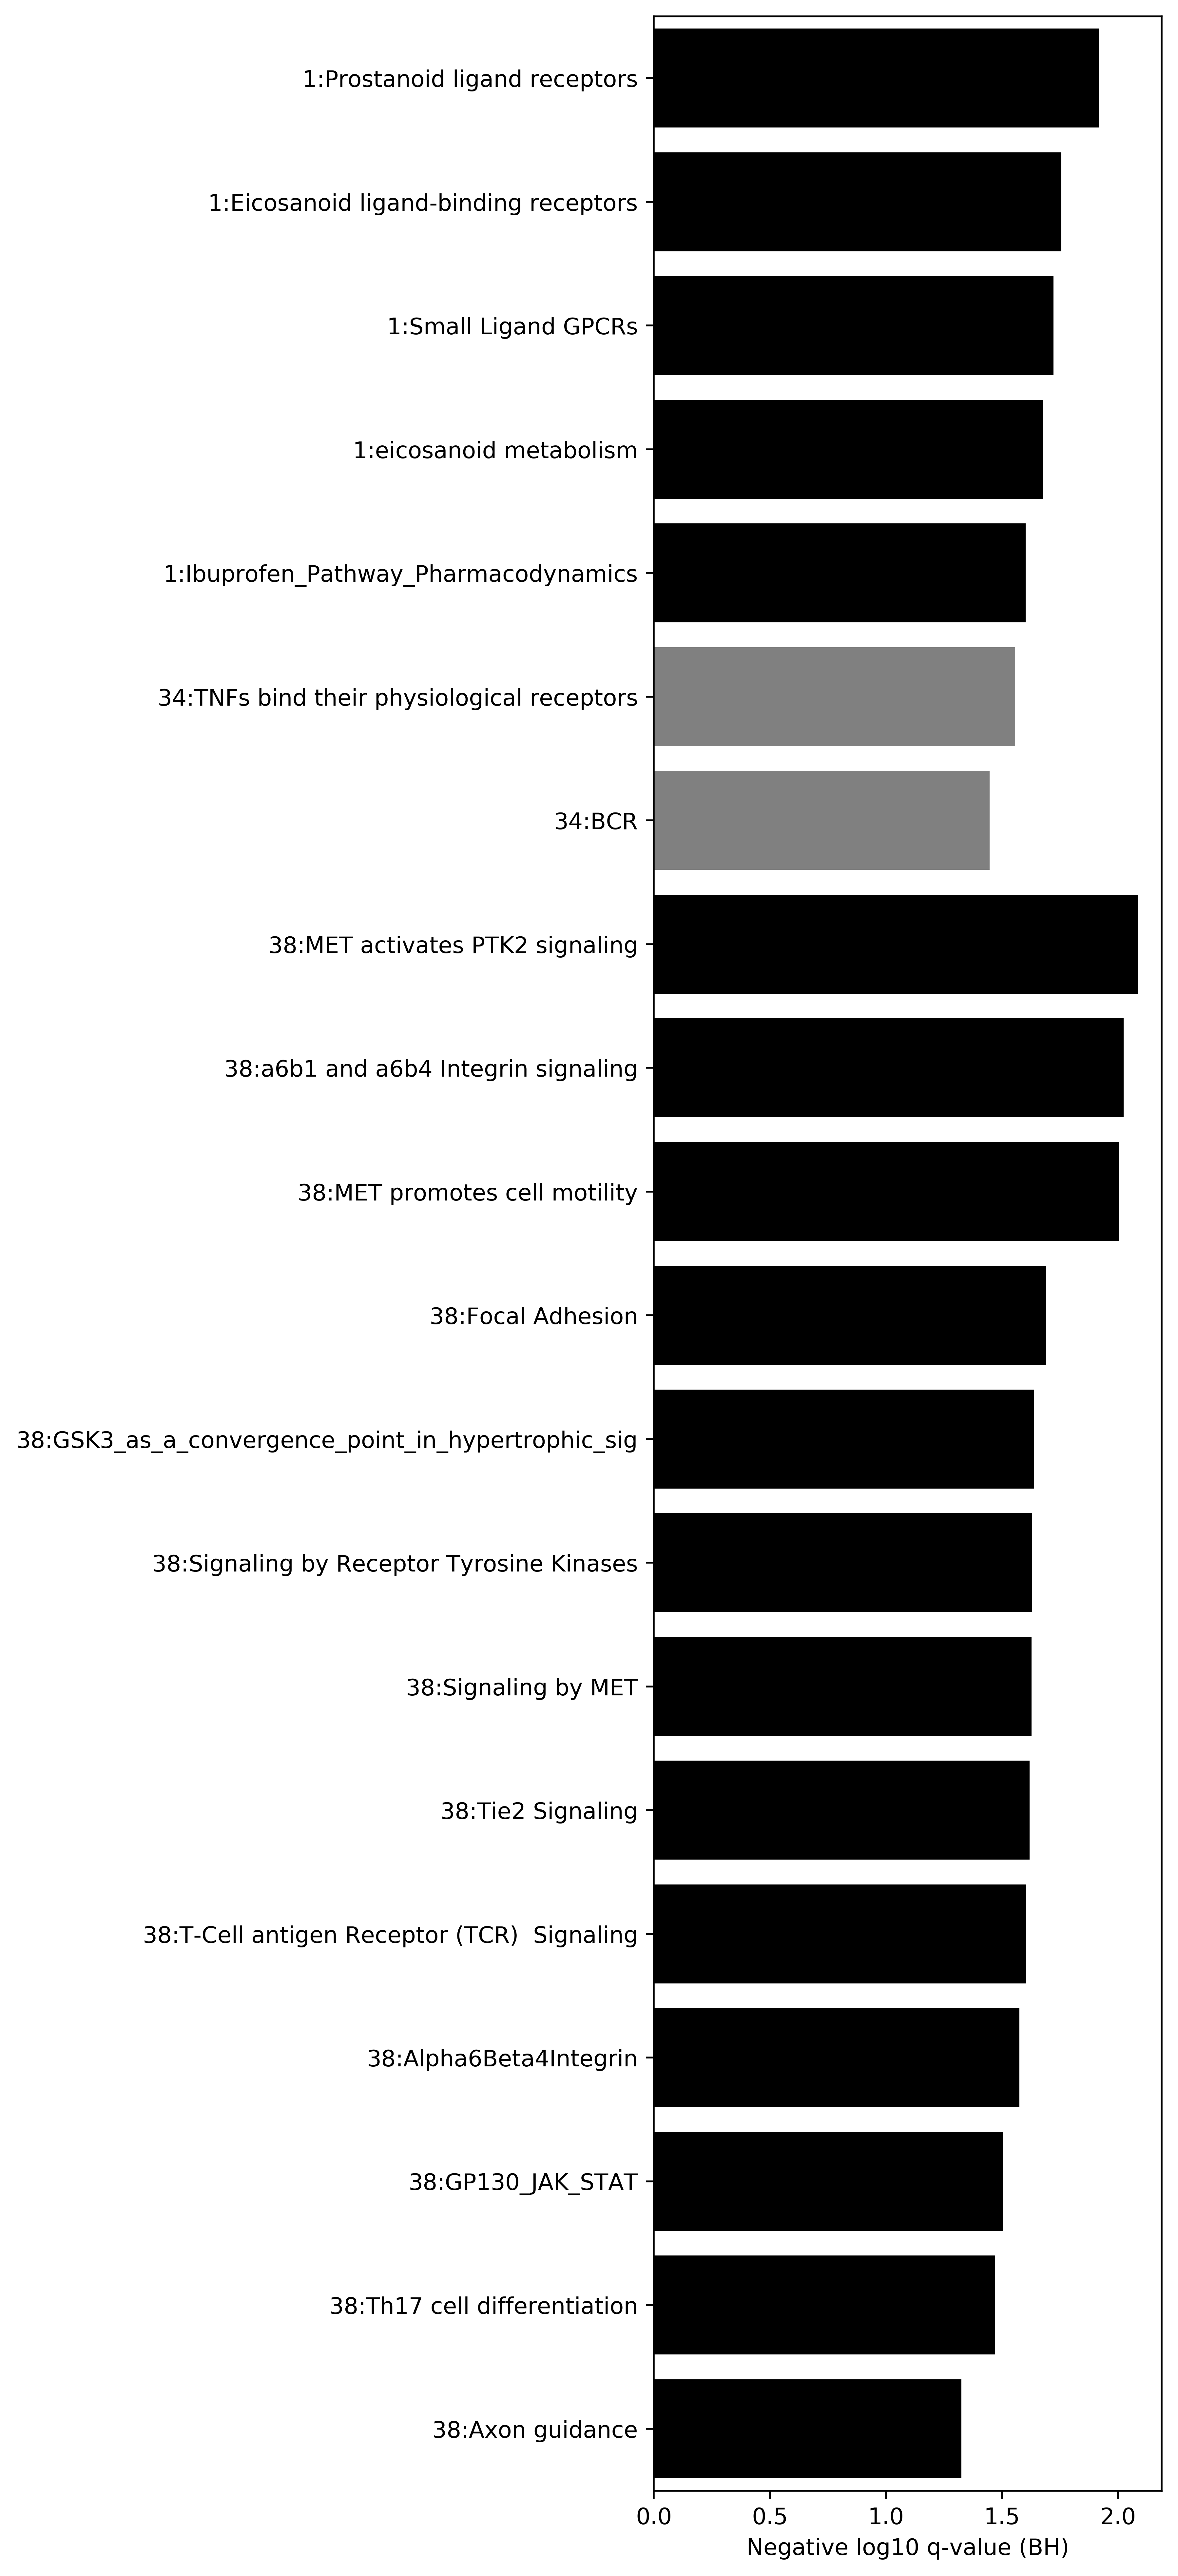

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

mypalette = dict()
is_grey = False
for topic in pathway_new.topic.unique():
    if not is_grey:
        mypalette[topic] = 'black'
        is_grey=True
    else:
        mypalette[topic] = 'grey'
        is_grey=False
        
fig,ax=plt.subplots(figsize=(4,20),dpi=500)
ax = sns.barplot(y="name", x="neg_log_q_BH", 
                 data=pathway_new,ax=ax,hue='topic',palette=mypalette,
                 dodge=False)
plt.xlabel('Negative log10 q-value (BH)')
plt.ylabel('')
plt.legend([],[], frameon=False)
plt.savefig(os.path.join(working_dir, "pathway_15topics.pdf"), bbox_inches = "tight")